## Лабораторная 3: метод ближайших соседей (kNN)

В рамках этого занятия мы будем создавать модель для предсказания выживших пассажиров на "Титанике" (классическое учебное Kaggle [соревнование](https://www.kaggle.com/c/titanic)).

![Титаник](http://staff.mmcs.sfedu.ru/~sguda/MachineLearning/titanic.png)

## 1

Загрузите данные о погибших в катастрофе с "Титаником". Целевым признаком здесь является факт спасения пассажира. Посмотрите на данные.

In [39]:
import pandas as pd

In [48]:
data = pd.read_csv('data.csv', delimiter=',')

In [49]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [50]:
# место для кода

Для простоты исключите пассажиров с неизвестным возрастом и заново перенумеруйте строки

*Функции, которые могут пригодиться при решении: `.dropna(subset=['Age']), .reset_index(drop=True)`*

In [51]:
data.dropna(subset=['Age'], inplace=True)
data.reset_index(drop=True)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
709,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
710,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
711,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
712,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


## 2

Постройте график рассеяния с возрастом в качестве оси абсцисс и ценой билета в качестве оси ординат. Отметьте красным — погибших, зеленым — спасшихся пассажиров. Постройте отдельно 2 графика: для женщин и для мужчин. 

Выполняется ли для данного множества гипотеза компактности?

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt

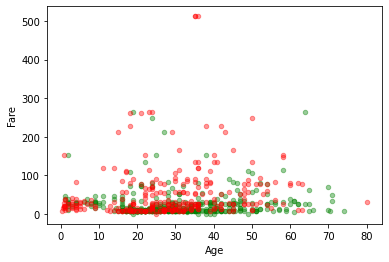

In [53]:
fig, axes = plt.subplots()
data.loc[data['Survived'] == 0].plot(x='Age',y='Fare',kind='scatter',color='green',ax=axes,alpha = 0.4)
data.loc[data['Survived'] == 1].plot(x='Age',y='Fare',kind='scatter',color='red',ax=axes,alpha = 0.4)

plt.show()

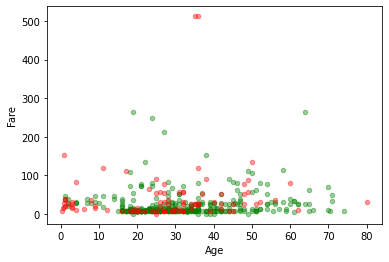

In [54]:
Men = data.loc[data['Sex'] == 'male', ['Survived', 'Age', 'Fare']]
Women = data.loc[data['Sex'] == 'female', ['Survived', 'Age', 'Fare']]
fig, axes = plt.subplots()
Men.loc[Men['Survived'] == 0].plot(x='Age',y='Fare',kind='scatter',color='green',ax=axes,alpha = 0.4)
Men.loc[Men['Survived'] == 1].plot(x='Age',y='Fare',kind='scatter',color='red',ax=axes,alpha = 0.4)

plt.show()

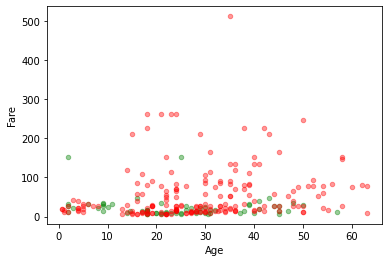

In [55]:
fig, axes = plt.subplots()
Women.loc[Women['Survived'] == 0].plot(x='Age',y='Fare',kind='scatter',color='green',ax=axes,alpha = 0.4)
Women.loc[Women['Survived'] == 1].plot(x='Age',y='Fare',kind='scatter',color='red',ax=axes,alpha = 0.4)

plt.show()

In [56]:
#гипотеза компактности не выполняется

## 3 

Для построения модели нам понадобится метрика близости пассажиров. Запрограммируем функцию вычисления расстояния между пассажирами:

In [57]:
def distance(a,b):
    d = 0
    d += abs(a['Pclass'] - b['Pclass'])
    d += a['Sex'] != b['Sex']
    d += abs(a['Age'] - b['Age'])
    d += abs(a['SibSp'] - b['SibSp'])
    d += abs(a['Parch'] - b['Parch'])
    d += abs(a['Fare'] - b['Fare'])
    d += a['Embarked'] != b['Embarked']
    return d

Метод `KNeighborsClassifier` из библиотеки `sklearn` излишне требователен к типам данных. Запрограммируем метод `k` ближайших соседей вручную:

In [58]:
import numpy as np
import tqdm

In [59]:
def myKNeighborsClassifier(learnData, K, passengerIndexForPrediction):
    dists = np.zeros((learnData.shape[0] - 1, 2))
    i = 0
    for idx, row in learnData.iterrows():
        if idx != passengerIndexForPrediction:  #LOO метод контроля ошибки
            dists[i][0] = distance(learnData.loc[passengerIndexForPrediction,], row)
            dists[i][1] = row['Survived']
            i += 1
    dists = sorted(dists, key = lambda pair: pair[0])
    prediction = 0
    for i in range(K): 
        prediction += dists[i][1]
    prediction /= K
    return round(prediction)

Запустите предсказание для всех пассажиров судна и, используя LOO-контроль ошибки оцените качество классификации:

In [38]:
accuracy = 0
for idx, row in tqdm.tqdm(data.iterrows(), total=len(data)):
    accuracy += row['Survived'] == myKNeighborsClassifier(data, 27, idx)
print(accuracy/data.shape[0])

100%|████████████████████████████████████████████████████████████████████████████████| 714/714 [01:57<00:00,  6.10it/s]

0.7226890756302521


Подберите слагаемые в метрике, их веса и количество соседей так, чтобы качество классификации было максимальным. 

Если функция на `python` работает долго, воспользуйтесь ее аналогом на 
С++:  `KNeighborsClassifier.cpp.` 

Компиляция на Linux выполняется командой 

    g++ -O2 KNeighborsClassifier.cpp -o  KNeighborsClassifier


Запуск: 

    ./KNeighborsClassifier
    
Построившему метрику с наилучшим качеством: +5 бонусных баллов.

## 4

Создайте копию функции `myKNeighborsClassifier` и измените ее так, чтобы она считала выступ объекта. Назовите ее `calcMargin`. 

Вычислите выступы для всех объектов и выведите информацию о пяти объектах с минимальным выступом (шумовых выбросах) и пяти объектах с максимальным выступом (эталонах). Объясните в комментариях полученные данные.

In [60]:
def calcMargin(learnData, K, passengerIndexForPrediction):
    dists = np.zeros((learnData.shape[0] - 1, 2))
    i = 0
    for idx, row in learnData.iterrows():
        if idx != passengerIndexForPrediction:  #LOO метод контроля ошибки
            dists[i][0] = distance(learnData.loc[passengerIndexForPrediction,], row)
            dists[i][1] = row['Survived']
            i += 1
    dists = sorted(dists, key = lambda pair: pair[0])
    margin = 0
    for i in range(K): 
        margin += dists[i][1]
    margin /= K
    return margin

In [61]:
margins = []

In [62]:
for idx, row in tqdm.tqdm(data.iterrows(), total=len(data)):
    margins.append(calcMargin(data, 27, idx))

100%|████████████████████████████████████████████████████████████████████████████████| 714/714 [02:00<00:00,  5.92it/s]


Это легче всего сделать с помощью функции `np.argsort`, возвращающей индексы элементов в отсортированном ряду:

In [63]:
idx = np.argsort(margins)
first = idx[:5]
last = idx[-5:]

In [64]:
print('Белые вороны (аномалии)')
for i in first:
    try:
        print(data.loc[i])
        print()
    except KeyError:
            continue

Белые вороны (аномалии)
PassengerId                                 69
Survived                                     1
Pclass                                       3
Name           Andersson, Miss. Erna Alexandra
Sex                                     female
Age                                       17.0
SibSp                                        4
Parch                                        2
Ticket                                 3101281
Fare                                     7.925
Cabin                                      NaN
Embarked                                     S
Name: 68, dtype: object

PassengerId                             659
Survived                                  0
Pclass                                    2
Name           Eitemiller, Mr. George Floyd
Sex                                    male
Age                                    23.0
SibSp                                     0
Parch                                     0
Ticket                             

In [65]:
print('Эталоны (характерные объекты)')
for i in last:
    try:
        print(data.loc[i])
        print()
    except KeyError:
            continue

Эталоны (характерные объекты)
PassengerId                    397
Survived                         0
Pclass                           3
Name           Olsson, Miss. Elina
Sex                         female
Age                           31.0
SibSp                            0
Parch                            0
Ticket                      350407
Fare                        7.8542
Cabin                          NaN
Embarked                         S
Name: 396, dtype: object

PassengerId                 281
Survived                      0
Pclass                        3
Name           Duane, Mr. Frank
Sex                        male
Age                        65.0
SibSp                         0
Parch                         0
Ticket                   336439
Fare                       7.75
Cabin                       NaN
Embarked                      Q
Name: 280, dtype: object

PassengerId                            665
Survived                                 1
Pclass                      

In [ ]:
#По данным видно что выживали женщины и дети или мужчины из 1 класса, менее повезло 2 и 3 классу 